# Tema 7: Transformada Cuántica de Fourier

En este notebook vamos a implementar la Transformada Cuántica de Fourier (QFT), que es el análogo cuántico de la transformada discreta de Fourier clásica. La QFT es uno de los algoritmos cuánticos fundamentales y constituye un componente clave en muchos algoritmos cuánticos importantes, como el algoritmo de Shor para la factorización de números enteros.

La QFT transforma un estado cuántico de la base computacional a la base de Fourier. Para un sistema de $n$ qubits, la QFT mapea el estado $|j\rangle$ a una superposición de todos los estados de la base computacional con fases específicas. Veremos cómo construir el circuito cuántico que implementa esta transformación y analizaremos su efecto sobre diversos estados de entrada para comprender mejor su funcionamiento y propiedades.

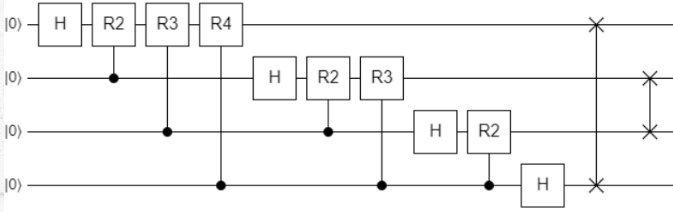

La Transformada Cuántica de Fourier (QFT) es el análogo cuántico de la Transformada Discreta de Fourier (DFT). Para un sistema de n qubits, la QFT actúa sobre los estados de la base computacional de la siguiente manera:
 
$$\text{QFT}|j\rangle = \frac{1}{\sqrt{2^n}} \sum_{k=0}^{2^n-1} e^{2\pi ijk/2^n}|k\rangle$$
 
donde $j$ y $k$ son enteros entre 0 y $2^n-1$.
 
**Representación en producto tensorial:**
 
La QFT puede expresarse de forma más conveniente usando la representación binaria de $j$. Si escribimos $j = j_1 j_2 \ldots j_n$ en binario (donde $j_1$ es el bit más significativo), entonces:
 
$$\text{QFT}|j_1 j_2 \ldots j_n\rangle = \frac{1}{\sqrt{2^n}} \bigotimes_{l=1}^{n} \left( |0\rangle + e^{2\pi i \cdot 0.j_l j_{l+1} \ldots j_n} |1\rangle \right)$$
 
donde $0.j_l j_{l+1} \ldots j_n$ representa la fracción binaria $\frac{j_l}{2} + \frac{j_{l+1}}{4} + \ldots + \frac{j_n}{2^{n-l+1}}$.
 
**Construcción del circuito:**
 
El circuito QFT se construye aplicando:
1. Una puerta Hadamard al primer qubit
2. Puertas de rotación de fase controladas $R_k$ donde $R_k = \begin{pmatrix} 1 & 0 \\ 0 & e^{2\pi i/2^k} \end{pmatrix}$
3. Se repite el proceso para cada qubit subsiguiente
4. Finalmente, se intercambian los qubits (operaciones SWAP) para invertir el orden
 
La complejidad del circuito QFT es $O(n^2)$, lo que representa una mejora exponencial sobre la DFT clásica que requiere $O(n \cdot 2^n)$ operaciones.

## Librerías

In [1]:
from qiskit import QuantumCircuit, QuantumRegister, transpile
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
import numpy as np

---
# Circuito cuántico

Para el circuito cuántico tendremos que tener n qubits, que definirán el tamaño de la QFT. Vamos a definirlo de forma que devolvamos directamente la gate de la QFT. Es importante darse cuenta de que por la forma que tiene qiskit de representar los qubits, tenemos que darle la vuelta a todos los qubits en el algoritmo.

In [2]:
def QFT(n:int):
    #Registros
    qr = QuantumRegister(n, 'QFTr')

    #Circuito
    qc = QuantumCircuit(qr, name='QFT')

    #Para cada qubit
    for i in range(n-1,-1,-1):
        #La primera H
        qc.h(i)
        for j in range(i-1,-1,-1):#Para los siguientes qubits
            #Puerta de fase controlada
            qc.cp(np.pi/2**(i-j), i, j)#Da igual el orden en el que se aplique

    #SWAPS finales
    for i in range(n//2):
        qc.swap(i,n-1-i)#Por parejas entre el 0 y el n-1, 1 y n-2, etc

    #Convertimos en gate
    QFT_Gate = qc.to_gate()

    return QFT_Gate

Veamos el circuito obtenido.

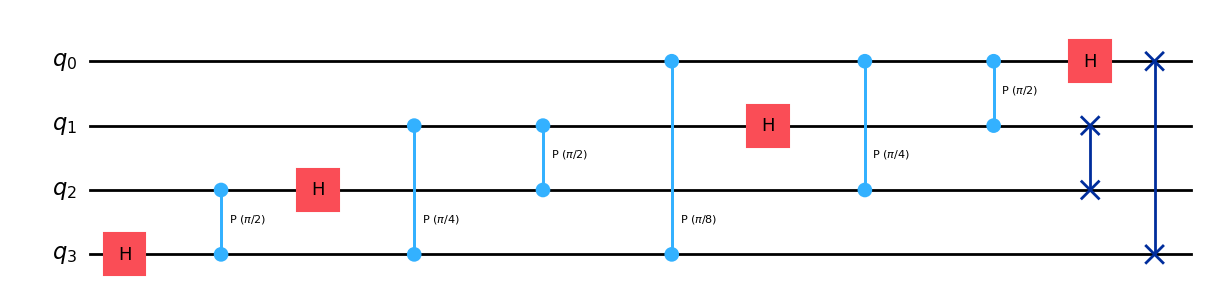

In [3]:
n = 4
qc = QuantumCircuit(n)
#Llamamos directamente a la puerta, sin necesidad de guardarla
qc.append(QFT(n), range(n))

#Descomponemos para ver el circuito
qc2 = qc.decompose('QFT', reps=1)
qc2.draw('mpl')

Vamos a aplicarla sobre un estado concreto. Este será un estado con unas amplitudes en forma de onda exponencial compleja oscilante. Podemos cambiar su frecuencia.

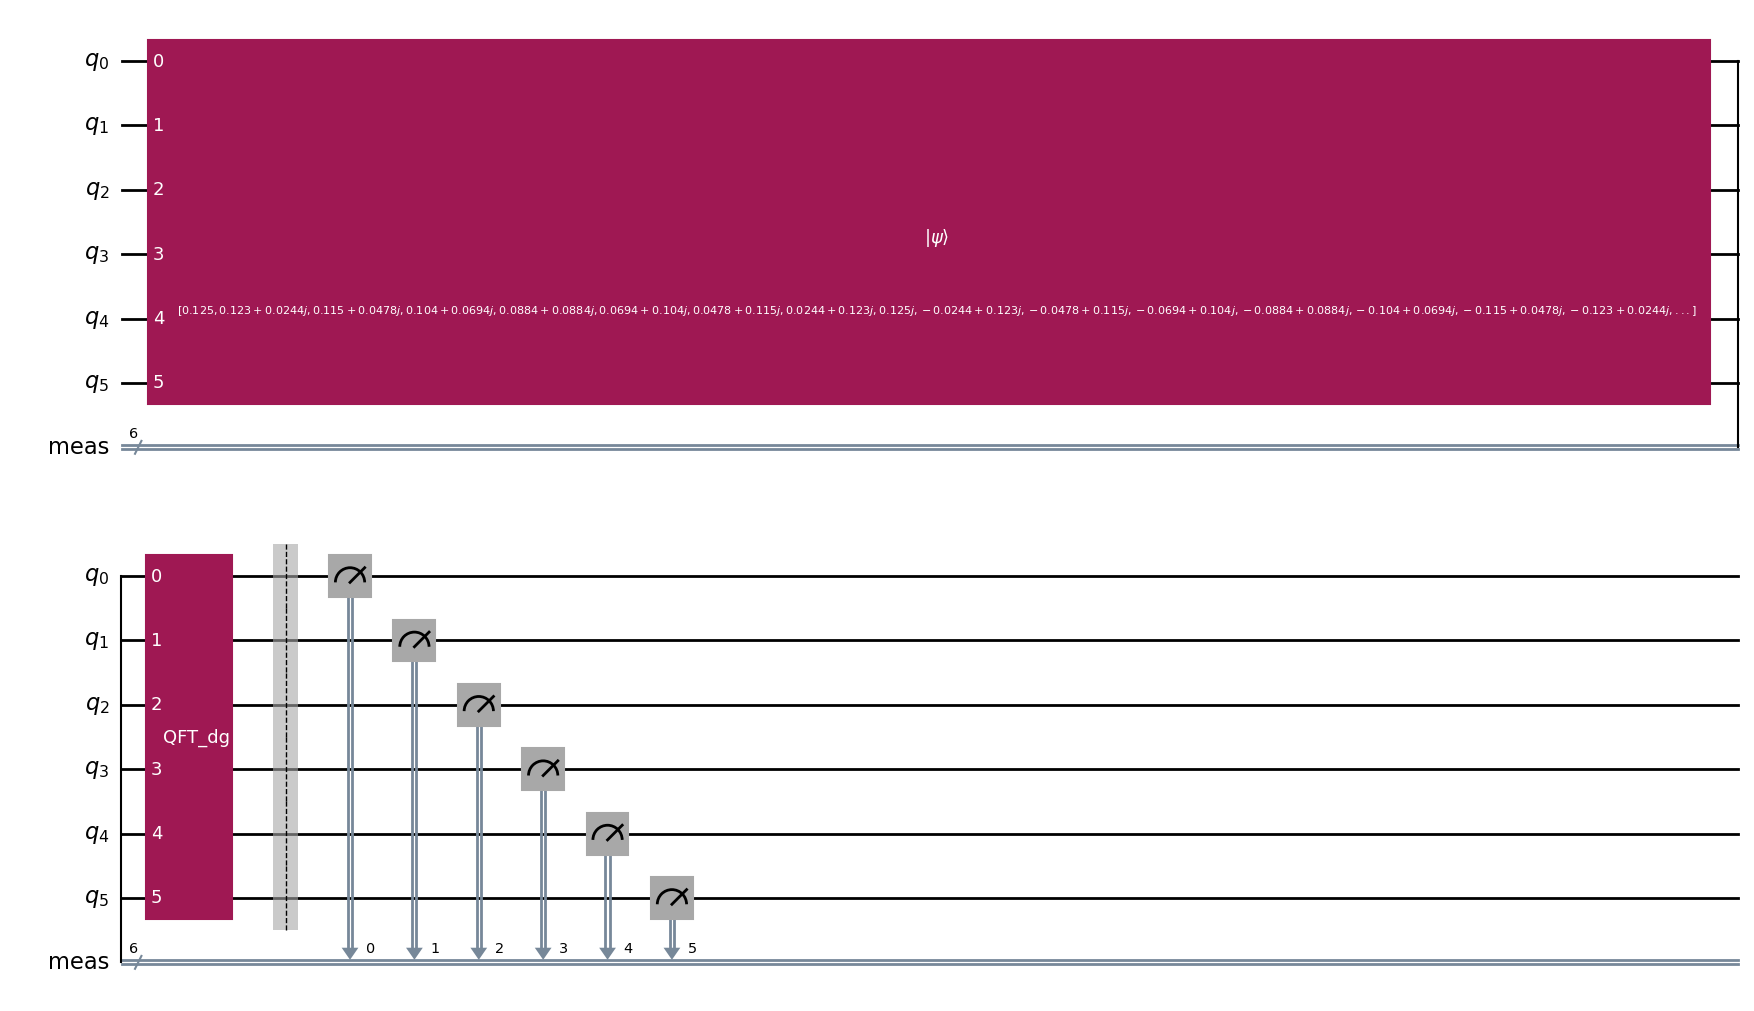

In [4]:
n = 6
frec = 2
#Estado cosenoidal
state = np.array([np.exp(2j*np.pi*frec*_/2**n) for _ in range(2**n)])

#Circuito cuantico
qc = QuantumCircuit(n)
#Inicializamos el estado cosenoidal
qc.initialize(state, range(n), normalize=True)

#Aplicamos la QFT
qc.append(QFT(n).inverse(), range(n))

#Medimos los qubits a ver cual obtiene mayor probabilidad
qc.measure_all()

qc.draw('mpl')

---
# Ejecutando el circuito

Ejecutamos el circuito en simulador.

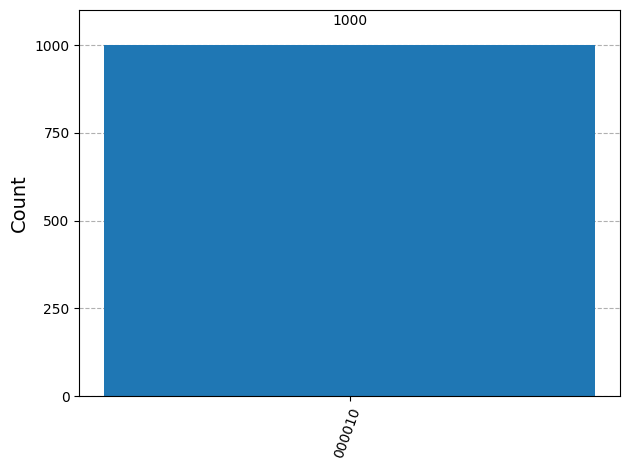

In [ ]:
#Número de shots
n_shots = 1000

#Simulador de n qubits
backend = AerSimulator()

#Transpilamos
qc_transpiled = transpile(qc, backend)

#Creamos el job con más shots para más precisión
job = backend.run(qc_transpiled, shots=n_shots)
#Obtenemos el resultado y sus cuentas
counts = job.result().get_counts()
#Ploteamos los histogramas de resultados
plot_histogram(counts)

Vemos que con frecuencia 2 obtenemos el resultado 2. Vamos a ir poniendo otras frecuencias.

---
# Jugando con las frecuencias

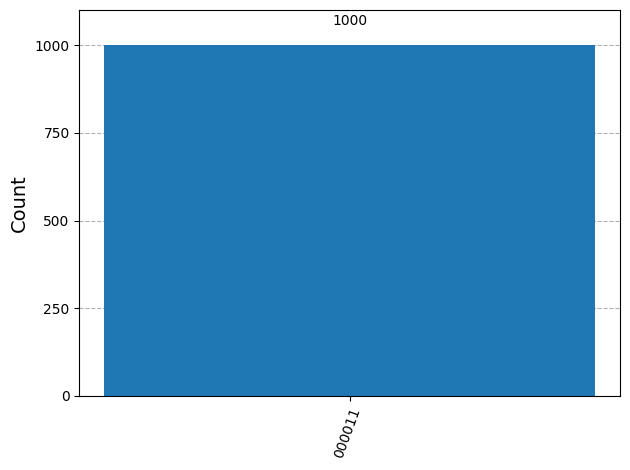

In [6]:
n = 6
frec = 3
#Estado cosenoidal
state = np.array([np.exp(2j*np.pi*frec*_/2**n) for _ in range(2**n)])

#Circuito cuantico
qc = QuantumCircuit(n)
#Inicializamos el estado cosenoidal
qc.initialize(state, range(n), normalize=True)

#Aplicamos la QFT
qc.append(QFT(n).inverse(), range(n))

#Medimos los qubits a ver cual obtiene mayor probabilidad
qc.measure_all()

#Número de shots
n_shots = 1000

#Simulador de n qubits
backend = AerSimulator()  # n)

#Transpilamos
qc_transpiled = transpile(qc, backend)

#Creamos el job con más shots para más precisión
job = backend.run(qc_transpiled, shots=n_shots)
#Obtenemos el resultado y sus cuentas
counts = job.result().get_counts()
#Ploteamos los histogramas de resultados
plot_histogram(counts)

Con frecuencia 3 obtenemos el 011, que es 3.

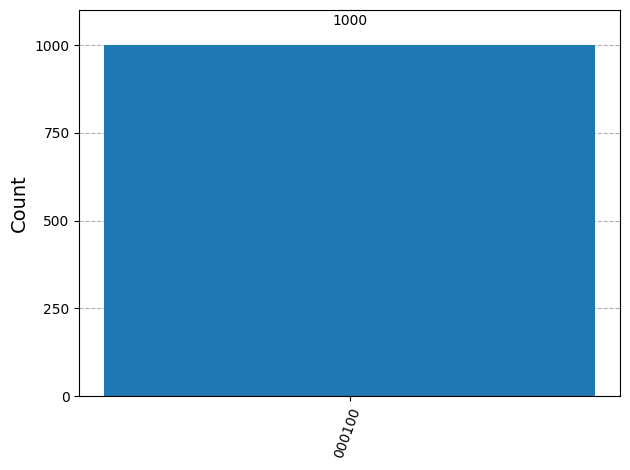

In [7]:
n = 6
frec = 4
#Estado cosenoidal
state = np.array([np.exp(2j*np.pi*frec*_/2**n) for _ in range(2**n)])

#Circuito cuantico
qc = QuantumCircuit(n)
#Inicializamos el estado cosenoidal
qc.initialize(state, range(n), normalize=True)

#Aplicamos la QFT
qc.append(QFT(n).inverse(), range(n))

#Medimos los qubits a ver cual obtiene mayor probabilidad
qc.measure_all()

#Número de shots
n_shots = 1000

#Simulador de n qubits
backend = AerSimulator()  # n)

#Transpilamos
qc_transpiled = transpile(qc, backend)

#Creamos el job con más shots para más precisión
job = backend.run(qc_transpiled, shots=n_shots)
#Obtenemos el resultado y sus cuentas
counts = job.result().get_counts()
#Ploteamos los histogramas de resultados
plot_histogram(counts)

Con 4 obtenemos el 0100, que es 4.

---
# Jugando con sumas de ondas

Vemos que, efectivamente, la QFT es una función que, si le damos un estado base x, nos devolverá una superposición con esa frecuencia en la fase. Ahora bien, ¿y si le ponemos dos frecuencias diferentes sumadas?

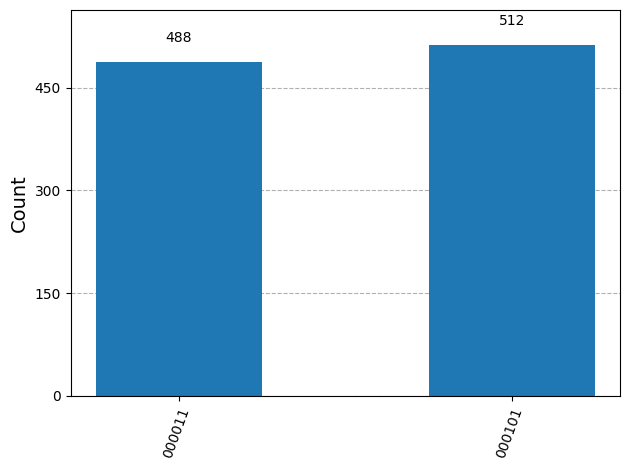

In [8]:
n = 6
frec1 = 3
frec2 = 5
#Estado cosenoidal
state = np.array([np.exp(2j*np.pi*frec1*_/2**n)+np.exp(2j*np.pi*frec2*_/2**n) for _ in range(2**n)])

#Circuito cuantico
qc = QuantumCircuit(n)
#Inicializamos el estado cosenoidal
qc.initialize(state, range(n), normalize=True)

#Aplicamos la QFT
qc.append(QFT(n).inverse(), range(n))

#Medimos los qubits a ver cual obtiene mayor probabilidad
qc.measure_all()

#Número de shots
n_shots = 1000

#Simulador de n qubits
backend = AerSimulator()  # n)

#Transpilamos
qc_transpiled = transpile(qc, backend)

#Creamos el job con más shots para más precisión
job = backend.run(qc_transpiled, shots=n_shots)
#Obtenemos el resultado y sus cuentas
counts = job.result().get_counts()
#Ploteamos los histogramas de resultados
plot_histogram(counts)

Vemos que obtenemos dos picos en la frecuencia 3 y la frecuencia 5 de misma altura. Por lo tanto, si ponemos dos estados x e y, nos devolverá la suma de las dos superposiciones, como la suma de dos ondas.

Vamos a darles proporciones diferentes a ambas ondas.

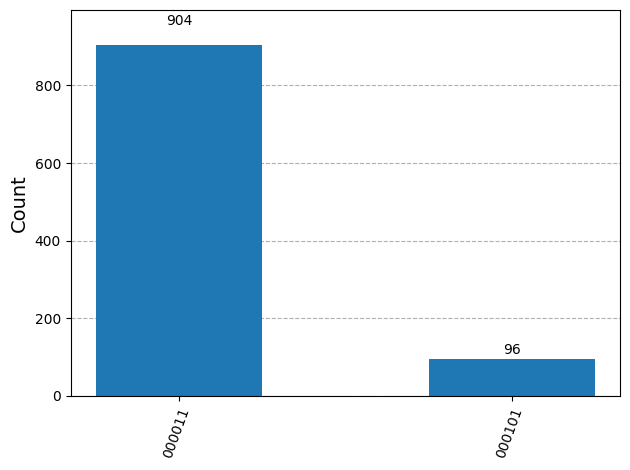

In [9]:
n = 6
frec1 = 3
frec2 = 5
#Estado cosenoidal
state = np.array([3*np.exp(2j*np.pi*frec1*_/2**n)+np.exp(2j*np.pi*frec2*_/2**n) for _ in range(2**n)])

#Circuito cuantico
qc = QuantumCircuit(n)
#Inicializamos el estado cosenoidal
qc.initialize(state, range(n), normalize=True)

#Aplicamos la QFT
qc.append(QFT(n).inverse(), range(n))

#Medimos los qubits a ver cual obtiene mayor probabilidad
qc.measure_all()

#Número de shots
n_shots = 1000

#Simulador de n qubits
backend = AerSimulator()  # n)

#Transpilamos
qc_transpiled = transpile(qc, backend)

#Creamos el job con más shots para más precisión
job = backend.run(qc_transpiled, shots=n_shots)
#Obtenemos el resultado y sus cuentas
counts = job.result().get_counts()
#Ploteamos los histogramas de resultados
plot_histogram(counts)

Vemos que el pico de la frecuencia 3 es 9 veces mayor ($3^2$) que el de la frecuencia 5. Por tanto, si ponemos dos estados x e y con amplitudes diferentes, estas amplitudes serán precisamente las amplitudes de cada una de las ondas de frecuencia x e y que sumaremos.

Como vemos, la QFT nos sirve para extraer las frecuencias (o espectro) que componen una onda, lo cual tiene una cantidad absurda de aplicaciones. Algunas son el análisis espectral, compresión de información, óptica, ecuaciones diferenciales, convolución, etc.

Ahora bien, ¿qué pasa si la frecuencia no es un número entero?

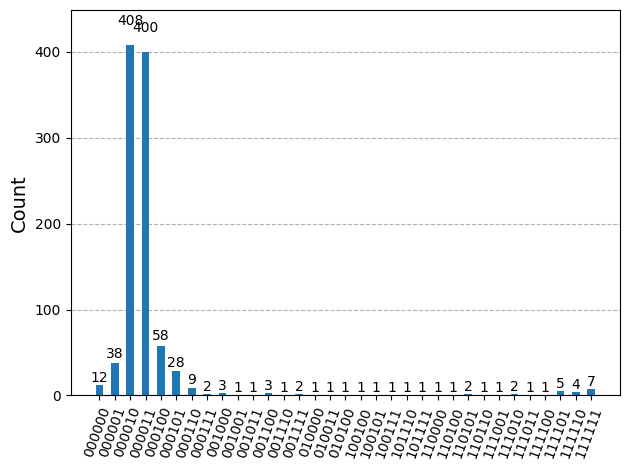

In [10]:
n = 6
frec = 2.5
#Estado cosenoidal
state = np.array([np.exp(2j*np.pi*frec*_/2**n)for _ in range(2**n)])

#Circuito cuantico
qc = QuantumCircuit(n)
#Inicializamos el estado cosenoidal
qc.initialize(state, range(n), normalize=True)

#Aplicamos la QFT
qc.append(QFT(n).inverse(), range(n))

#Medimos los qubits a ver cual obtiene mayor probabilidad
qc.measure_all()

#Número de shots
n_shots = 1000

#Simulador de n qubits
backend = AerSimulator()  # n)

#Transpilamos
qc_transpiled = transpile(qc, backend)

#Creamos el job con más shots para más precisión
job = backend.run(qc_transpiled, shots=n_shots)
#Obtenemos el resultado y sus cuentas
counts = job.result().get_counts()
#Ploteamos los histogramas de resultados
plot_histogram(counts)

Vemos que hay una distribución, con un pico que comprende 2 y 3. Esto es lo esperado, ya que la frecuencia real está entre 2 y 3.

---
# Ejercicio

Haz la misma prueba con la suma de dos frecuencias no enteras de diferente altura.

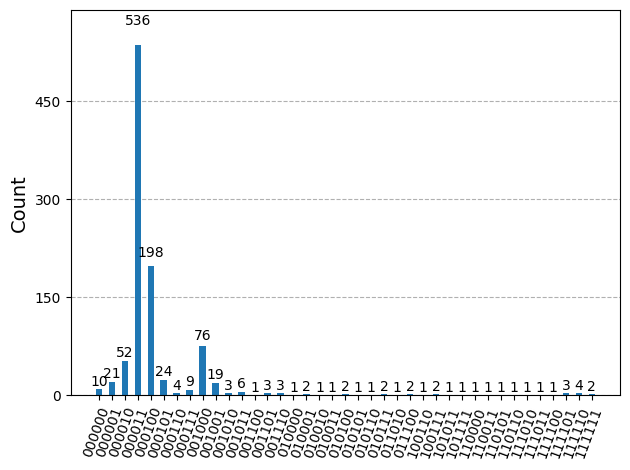

In [11]:
n = 6
frec1 = 3.4
frec2 = 7.6
#Estado cosenoidal
state = np.array([3*np.exp(2j*np.pi*frec1*_/2**n)+np.exp(2j*np.pi*frec2*_/2**n) for _ in range(2**n)])

#Circuito cuantico
qc = QuantumCircuit(n)
#Inicializamos el estado cosenoidal
qc.initialize(state, range(n), normalize=True)

#Aplicamos la QFT
qc.append(QFT(n).inverse(), range(n))

#Medimos los qubits a ver cual obtiene mayor probabilidad
qc.measure_all()

#Número de shots
n_shots = 1000

#Simulador de n qubits
backend = AerSimulator()  # n)

#Transpilamos
qc_transpiled = transpile(qc, backend)

#Creamos el job con más shots para más precisión
job = backend.run(qc_transpiled, shots=n_shots)
#Obtenemos el resultado y sus cuentas
counts = job.result().get_counts()
#Ploteamos los histogramas de resultados
plot_histogram(counts)

---
# Ejercicio

Descompon con la QFT inversa el espectro de una serie de datos.

---
# Función de Qiskit

En Qiskit ya existe una función que realiza esta puerta. Esta es QFTGate. Esta función permite indicarle el número de qubits.

In [14]:
from qiskit.circuit.library import QFTGate 

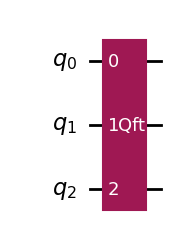

In [15]:
qc = QuantumCircuit(3)
qc.append(QFTGate(3),range(3))
qc.draw('mpl')